In [24]:
import psycopg2
import re
import matplotlib.pyplot as plt

In [25]:
database_setup = {
    'host' : '127.0.0.11'
    ,'database': 'ZSBD_p1_restore'
    ,'user' : 'inzdanych123'
    ,'password' : 'inzdanych123'
    ,'port' : '5432'
}

In [26]:
def do_query(query, print_out = False, commit = False):
    try:
        con = psycopg2.connect(
                    host = database_setup['host'],
                    database = database_setup['database'],
                    user = database_setup['user'],
                    password = database_setup['password'],
                    port = database_setup['port'])

        cur = con.cursor()

        cur.execute(query)
        
        for notice in con.notices:
            print(notice)

        if commit:
            con.commit()

        if print_out:
            column_names = [desc[0] for desc in cur.description]
            row_list = []
            row = cur.fetchone()
            while row is not None:
                row_list.append(row)
                #print(row)
                row = cur.fetchone()
            df = pd.DataFrame(row_list, columns=column_names)
            print(df)
            print('\n')
        
        cur.close()
        con.close()

    except (Exception, psycopg2.DatabaseError) as error:
            print(error)

    finally:
        if con is not None:
            con.close()

In [27]:
# do_query("""
# create extension pg_trgm with schema ai_med;

# create extension intarray with schema ai_med; 

# alter user inzdanych set search_path = 'ai_med,public,view_holder,...';
# """
# ,commit=True
# ,print_out=True)

In [28]:
#część odpowiedzialna za łączenie się z bazą, wywoływanie zapytań, obsługiwanie błędów, zwracanie napotkanych wartości
def index_tester(what_index, Query, Drop):
    try:
        con = psycopg2.connect(
                    host = database_setup['host'],
                    database = database_setup['database'],
                    user = database_setup['user'],
                    password = database_setup['password'],
                    port = database_setup['port'])
        cur = con.cursor()

        cur.execute(Drop)

        if what_index != None:
            cur.execute(what_index)

        cur.execute(Query)

        for notice in con.notices:
            print(notice)

        query_output = cur.fetchall()
        
        if query_output != None:
            return query_output

    except (Exception, psycopg2.Error) as error:
        return error
    
    finally:
        if con:
            cur.close()
            con.close()

In [29]:
def index_tester_all(Q, D, index_query):
    #index_list = [None, 'btree', 'HASH', 'gist', 'spgist', 'gin', 'BRIN']
    index_list = [None, 'btree', 'HASH', 'gin', 'BRIN']

    seq_scan_dict_floats_planning = {}
    seq_scan_dict_floats_executing = {}
    planning_time = []
    execution_time = []
    planning_time_non_seq = []
    execution_time_non_seq = []

    for index in index_list:
        #testowanie poszczególnych rodzajów indeksów 
        if index == None:
            mes = index_tester(None, Q, D)
        elif index == 'gin':
            mes = index_tester((index_query.split(");")[0] + " ai_med.gin_trgm_ops);") %(index), Q, D)
        else:
            mes = index_tester(index_query %(index), Q, D)

        if type(mes) == list:
            #odczytywanie wartości z EXPLAIN ANALYZE
            if str(mes[0]).split('on')[0] == "('Seq Scan ":
                #zapis dla wartości (czasów), dla których w zapytaniu NIE został wykorzystany konkretny indeks  
                planning_time.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][0]))[0]))
                execution_time.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][1]))[0]))

                seq_scan_dict_floats_planning['seq scan'] = planning_time
                seq_scan_dict_floats_executing['seq scan'] = execution_time 
            else:
                #zapis dla wartości (czasów), dla których w zapytaniu został wykorzystany konkretny indeks  
                planning_time_non_seq.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][0]))[0]))
                execution_time_non_seq.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][1]))[0]))

                seq_scan_dict_floats_planning[index] = float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][0]))[0])
                seq_scan_dict_floats_executing[index] = float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][1]))[0])
        else:
            print(index, ' zwrocil blad:', '\n', mes)
    
    if len(seq_scan_dict_floats_executing) == 1:
        print("DO TEGO POLECENIA TESTOWANE INDEKS-y, NIE ZMIENIAJĄ SPOSOBU WYSZUKIWANIA \n POZOSTAJE SEQ SCAN \n \n JEŻELI WYSTĘPUJĄ PATRZ NA BŁĘDY")
    else:
        #wizualizacja zapisanych wcześniej wartości
        print("DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY")
        try:
            seq_scan_dict_floats_executing['seq scan'] = seq_scan_dict_floats_executing['seq scan'][0]
            seq_scan_dict_floats_planning['seq scan'] = seq_scan_dict_floats_planning['seq scan'][0]
            seq_scan_dict_floats_executing['no index'] = seq_scan_dict_floats_executing.pop('seq scan')
            seq_scan_dict_floats_planning['no index'] = seq_scan_dict_floats_planning.pop('seq scan')
        except(TypeError):
            pass
        
        print(seq_scan_dict_floats_planning)
        fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100)
        fig.tight_layout()
        
        names = list(seq_scan_dict_floats_planning.keys())
        values = list(seq_scan_dict_floats_planning.values())
        ax1.bar(range(len(seq_scan_dict_floats_planning)), values, tick_label=names)
        ax1.set_ylabel('t [ms]')
        ax1.set_title('planning time')

        names = list(seq_scan_dict_floats_executing.keys())
        values = list(seq_scan_dict_floats_executing.values())
        ax2.bar(range(len(seq_scan_dict_floats_executing)), values, tick_label=names)
        ax2.set_ylabel('t [ms]')
        ax2.set_title('executing time')
        plt.show()

In [30]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.objawy WHERE bol_glowy is TRUE;'
index_name_query = 'data_bol'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med.objawy using %s (bol_glowy);' 

In [31]:
index_tester_all(Q, D, index_query)

NOTICE:  index "data_bol" does not exist, skipping

NOTICE:  index "data_bol" does not exist, skipping

NOTICE:  index "data_bol" does not exist, skipping

gin  zwrocil blad: 
 operator class "ai_med.gin_trgm_ops" does not accept data type boolean

BRIN  zwrocil blad: 
 data type boolean has no default operator class for access method "brin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

DO TEGO POLECENIA TESTOWANE INDEKS-y, NIE ZMIENIAJĄ SPOSOBU WYSZUKIWANIA 
 POZOSTAJE SEQ SCAN 
 
 JEŻELI WYSTĘPUJĄ PATRZ NA BŁĘDY


In [32]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.objawy WHERE bol_glowy = TRUE;'
index_name_query = 'data_bol'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med.objawy using %s (bol_glowy);' 

In [33]:
index_tester_all(Q, D, index_query)

NOTICE:  index "data_bol" does not exist, skipping

NOTICE:  index "data_bol" does not exist, skipping

NOTICE:  index "data_bol" does not exist, skipping

gin  zwrocil blad: 
 operator class "ai_med.gin_trgm_ops" does not accept data type boolean

BRIN  zwrocil blad: 
 data type boolean has no default operator class for access method "brin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

DO TEGO POLECENIA TESTOWANE INDEKS-y, NIE ZMIENIAJĄ SPOSOBU WYSZUKIWANIA 
 POZOSTAJE SEQ SCAN 
 
 JEŻELI WYSTĘPUJĄ PATRZ NA BŁĘDY


In [34]:
Q = "EXPLAIN ANALYSE SELECT * FROM ai_med.pacjent WHERE imie = 'Robert';"
index_name_query = 'imie_pacjenta'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med.pacjent using %s (imie);'

NOTICE:  index "imie_pacjenta" does not exist, skipping

NOTICE:  index "imie_pacjenta" does not exist, skipping

NOTICE:  index "imie_pacjenta" does not exist, skipping

NOTICE:  index "imie_pacjenta" does not exist, skipping

NOTICE:  index "imie_pacjenta" does not exist, skipping

DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY
{'btree': 1.962, 'HASH': 2.26, 'gin': 4.403, 'no index': 5.401}


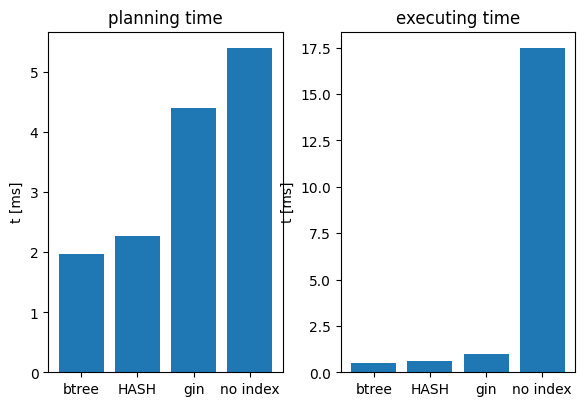

In [35]:
index_tester_all(Q, D, index_query)

In [36]:
Q = "EXPLAIN ANALYSE SELECT * FROM ai_med.pacjent WHERE imie LIKE('Jan');"
index_name_query = 'imie_pacjenta'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med.pacjent using %s (imie);'

NOTICE:  index "imie_pacjenta" does not exist, skipping

NOTICE:  index "imie_pacjenta" does not exist, skipping

NOTICE:  index "imie_pacjenta" does not exist, skipping

NOTICE:  index "imie_pacjenta" does not exist, skipping

NOTICE:  index "imie_pacjenta" does not exist, skipping

DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY
{'btree': 4.377, 'HASH': 3.058, 'gin': 2.354, 'no index': 2.687}


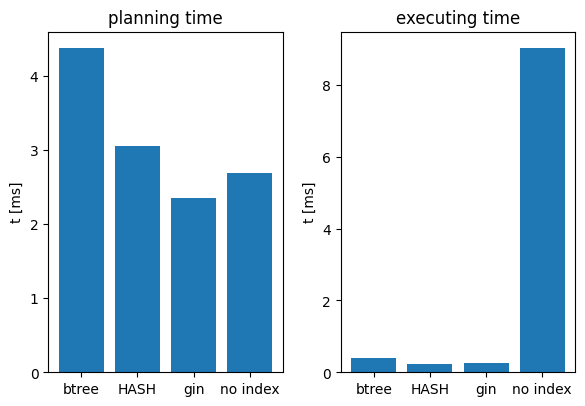

In [37]:
index_tester_all(Q, D, index_query)

In [38]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med."leczenie_w_kierunku_kod_ICD_10"' + " WHERE data_zakonczenia_leczenia_i10 >= '2021-02-01' "
Q+= "AND data_zakonczenia_leczenia_i10 <= '2021-02-28';"
index_name_query = 'data_icd_10'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med."leczenie_w_kierunku_kod_ICD_10" using %s (data_zakonczenia_leczenia_i10);' 

NOTICE:  index "data_icd_10" does not exist, skipping

NOTICE:  index "data_icd_10" does not exist, skipping

NOTICE:  index "data_icd_10" does not exist, skipping

gin  zwrocil blad: 
 operator class "ai_med.gin_trgm_ops" does not accept data type date

NOTICE:  index "data_icd_10" does not exist, skipping

DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY
{'btree': 4.495, 'no index': 7.91}


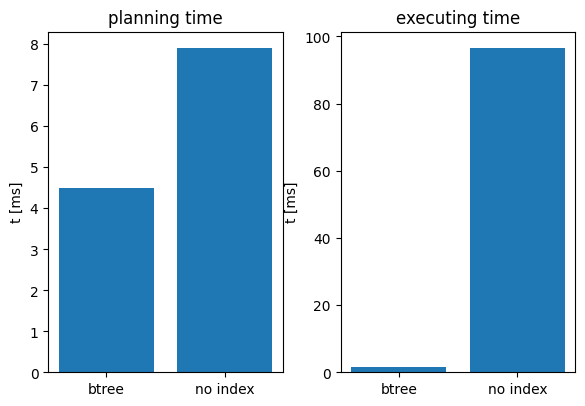

In [39]:
index_tester_all(Q, D, index_query)

In [40]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.morfologia' + " WHERE mcv >= 20.0 AND mcv <= 30.0;"
index_name_query = 'mcv_test'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med.morfologia using %s (mcv);' 

NOTICE:  index "mcv_test" does not exist, skipping

NOTICE:  index "mcv_test" does not exist, skipping

NOTICE:  index "mcv_test" does not exist, skipping

gin  zwrocil blad: 
 operator class "ai_med.gin_trgm_ops" does not accept data type real

NOTICE:  index "mcv_test" does not exist, skipping

DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY
{'btree': 4.825, 'no index': 14.235}


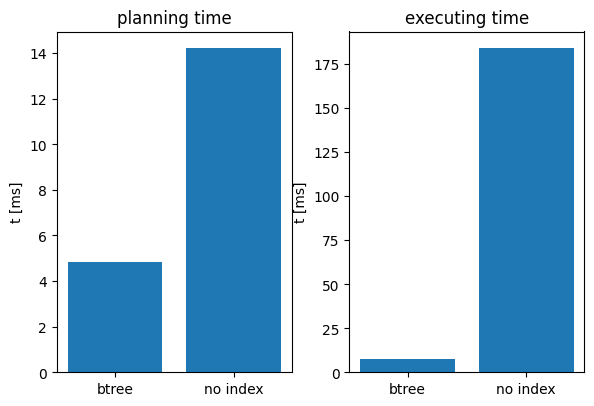

In [41]:
index_tester_all(Q, D, index_query)

In [42]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.morfologia' + " WHERE mcv >= 55.0;"
index_name_query = 'mcv_test'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med.morfologia using %s (mcv);' 

In [43]:
index_query

'CREATE INDEX mcv_test on ai_med.morfologia using %s (mcv);'

NOTICE:  index "mcv_test" does not exist, skipping

NOTICE:  index "mcv_test" does not exist, skipping

NOTICE:  index "mcv_test" does not exist, skipping

gin  zwrocil blad: 
 operator class "ai_med.gin_trgm_ops" does not accept data type real

NOTICE:  index "mcv_test" does not exist, skipping

DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY
{'btree': 3.842, 'no index': 2.733}


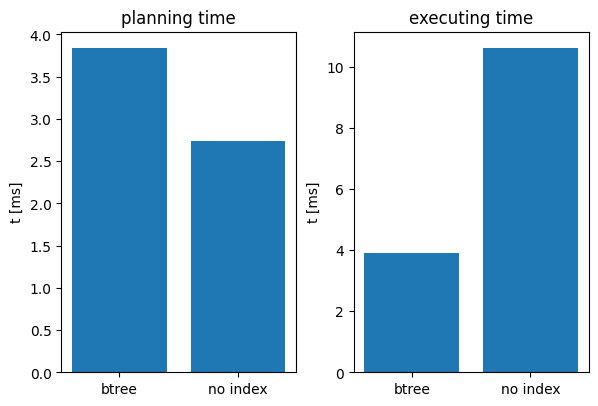

In [44]:
index_tester_all(Q, D, index_query)

In [45]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med."Nazwa pliku z notatkami lekarskimi"' +  " WHERE lekarz_rodzinny LIKE ('%e1920%');"
index_name_query = 'notatki_plik_test'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med."Nazwa pliku z notatkami lekarskimi" using %s (lekarz_rodzinny);'

NOTICE:  index "notatki_plik_test" does not exist, skipping

NOTICE:  index "notatki_plik_test" does not exist, skipping

NOTICE:  index "notatki_plik_test" does not exist, skipping

NOTICE:  index "notatki_plik_test" does not exist, skipping

NOTICE:  index "notatki_plik_test" does not exist, skipping

DODATKOWO, JEŻELI WYSTĘPUJĄ - PATRZ NA BŁĘDY
{'gin': 7.227, 'no index': 17.414}


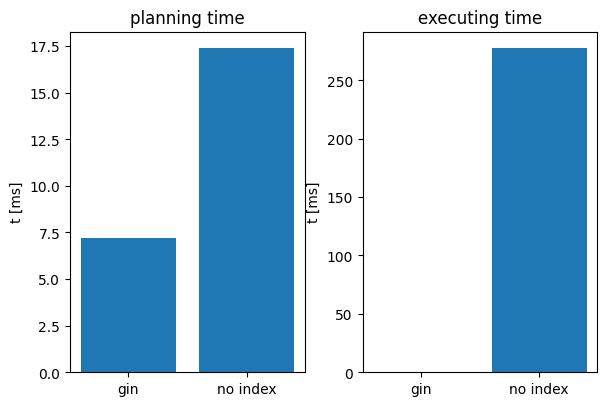

In [46]:
index_tester_all(Q, D, index_query)